## Libraries

In [132]:
# Importing libraries
import time, psutil, os, math
from tqdm.contrib import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

In [133]:
# Runtime and memory usage
start = time.time()
process = psutil.Process(os.getpid())

## Data

In [134]:
# Loading the data
data = pd.read_csv('data/training.zip')
print(pd.Series({"Memory usage": "{:.4f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage       62.9426 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


## Logistic Function

In [135]:
# Logistic function
def logistic(x):
    """
    Computes the logistic function applied to an input scalar/array
    Args:
        x (scalar/ndarray): scalar or numpy array of any size
    Returns:
        y (scalar/ndarray): logistic function applied to x, has the same shape as x
    """
    y = 1 / (1 + np.exp(-x))
    return y

x, x_arr = 0, np.array([-5, -1, 1, 5])
print(f"logistic({x}) = {logistic(x)}")
print(f"logistic({x_arr}) = {logistic(x_arr)}")

logistic(0) = 0.5
logistic([-5 -1  1  5]) = [0.00669285 0.26894142 0.73105858 0.99330715]


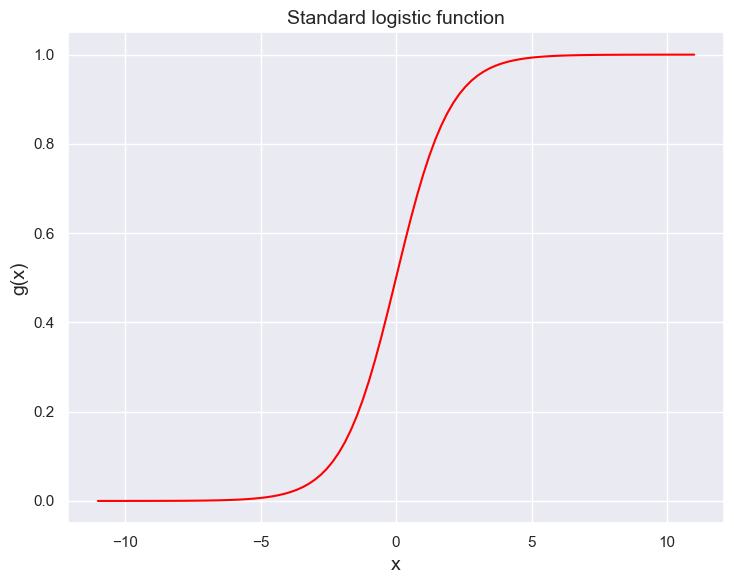

In [136]:
# Plotting the logistic function
plt.figure(figsize = (7.5, 6))
x = np.linspace(-11, 11, 100)
plt.plot(x, logistic(x), color = 'red')
plt.xlabel("x", fontsize = 14)
plt.ylabel("g(x)", fontsize = 14)
plt.title("Standard logistic function", fontsize = 14)
plt.tight_layout()
plt.show()

## Log Loss

In [137]:
# Log loss
def log_loss(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (scalar): true value (0 or 1)
      y_dash (scalar): predicted value (probability of y being 1)
    Returns:
      loss (float): nonnegative loss corresponding to y and y_dash
    """
    loss = - (y * np.log(y_dash)) - ((1 - y) * np.log(1 - y_dash))
    return loss

y, y_dash = 0, 0.6
print(f"log_loss({y}, {y_dash}) = {log_loss(y, y_dash)}")

log_loss(0, 0.6) = 0.916290731874155


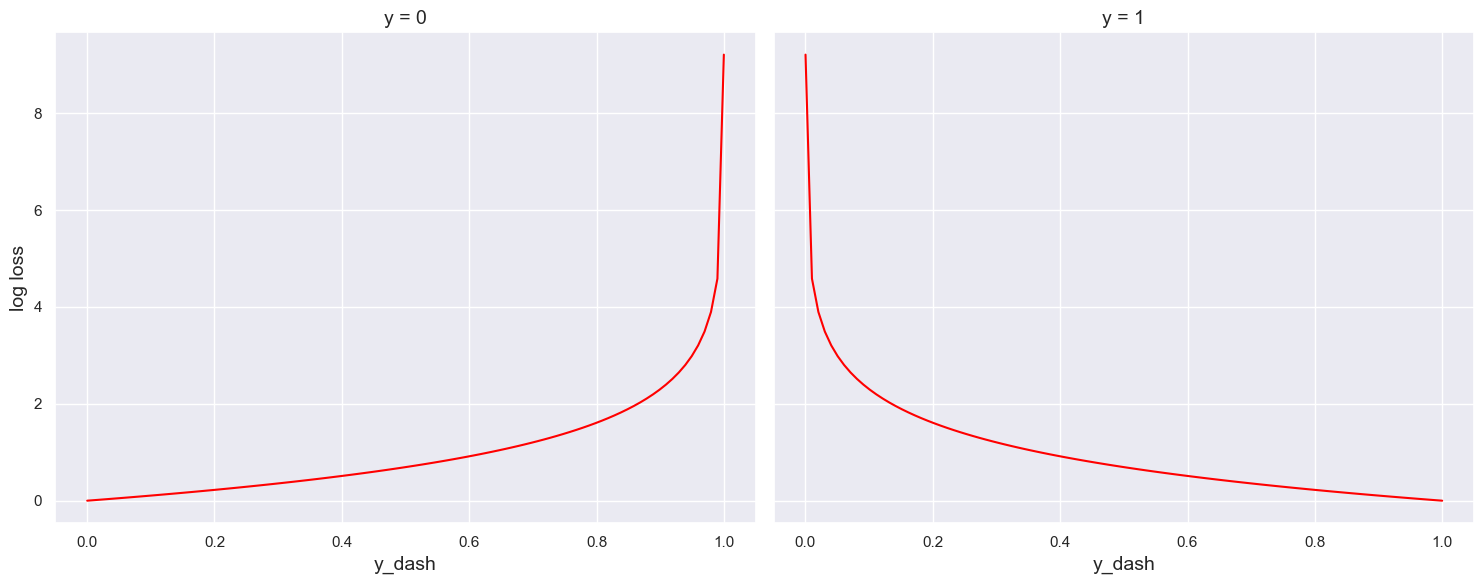

In [138]:
# Log loss for y = 0 and y = 1
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)
y_dash = np.linspace(0.0001, 0.9999, 100)
ax[0].plot(y_dash, log_loss(0, y_dash), color = 'red')
ax[0].set_title("y = 0", fontsize = 14)
ax[0].set_xlabel("y_dash", fontsize = 14)
ax[0].set_ylabel("log loss", fontsize = 14)
ax[1].plot(y_dash, log_loss(1, y_dash), color = 'red')
ax[1].set_title("y = 1", fontsize = 14)
ax[1].set_xlabel("y_dash", fontsize = 14)
plt.tight_layout()
plt.show()

## Cost Function

In [139]:
# Cost function - using for loop
def cost_func(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    cost = 0
    for i in range(m):
        cost += log_loss(y[i], y_dash[i])
    cost = cost / m
    return cost

y, y_dash = np.array([0, 1, 0]), np.array([0.4, 0.6, 0.25])
print(f"cost_func({y}, {y_dash}) = {cost_func(y, y_dash)}")

cost_func([0 1 0], [0.4  0.6  0.25]) = 0.43644443999458743


In [140]:
# Cost function - using vectorization
def cost_func_vec(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    loss_vec = np.array([log_loss(y[i], y_dash[i]) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    return cost

y, y_dash = np.array([0, 1, 0]), np.array([0.4, 0.6, 0.25])
print(f"cost_func_vec({y}, {y_dash}) = {cost_func(y, y_dash)}")

cost_func_vec([0 1 0], [0.4  0.6  0.25]) = 0.43644443999458743


In [141]:
# Function to compute cost function in terms of model parameters - using for loops
def cost_logreg(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = []
    for i in range(m):
        s = 0
        for j in range(n):
            s += X[i, j] * w[j]
        z.append(s + b)
    z = np.array(z)
    y_dash = logistic(z)
    cost = cost_func(y, y_dash)
    return cost

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost_logreg(X = {X}, y = {y}, w = {w}, b = {b}) = {cost_logreg(X, y, w, b)}")

cost_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


In [142]:
# Function to compute cost function in terms of model parameters - using vectorization
def cost_logreg_vec(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = logistic(z)
    cost = cost_func_vec(y, y_dash)
    return cost

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {cost_logreg(X, y, w, b)}")

cost_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


[Text(0.5, 0, 'w'), Text(0.5, 0.5, 'b')]

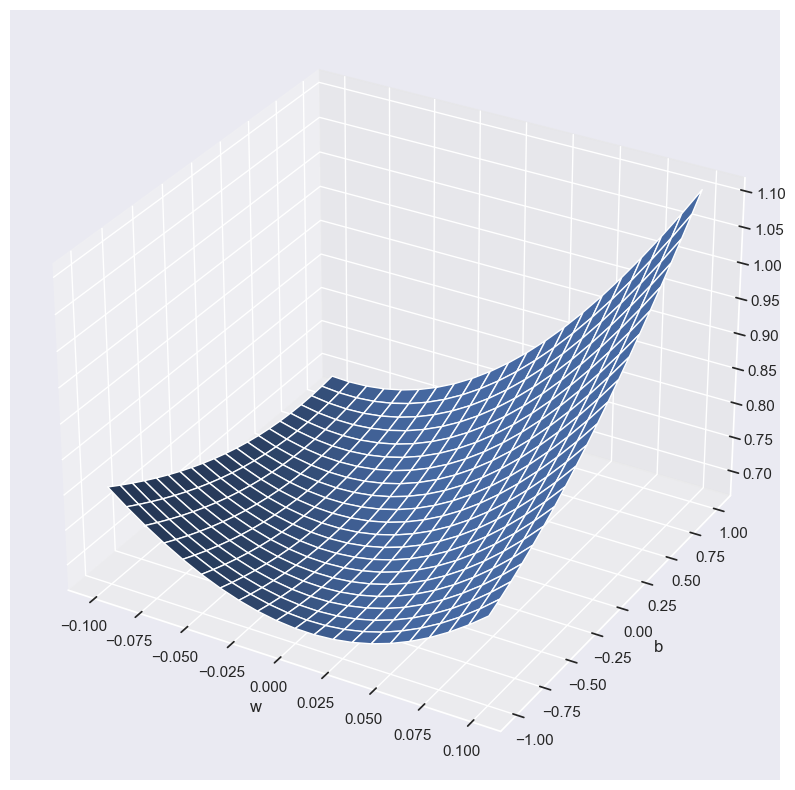

In [143]:
# Plotting the cost function against model parameters
from mpl_toolkits.mplot3d import Axes3D
w, b = np.meshgrid(np.linspace(-0.1, 0.1, 21), np.linspace(-1, 1, 21))
X = np.array([1.56, 0.76 , 0.08, 9.71, 4.65, 4.35, 7.34, 0.91, 9.82, 9.05]).reshape((10, 1))
y = np.array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])
cost = np.array([[cost_logreg_vec(X, y, np.array([w0]), b0) for b0 in b[:, 0]] for w0 in w[0]])
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')
ax.plot_surface(w, b, cost)
ax.set(xlabel = "w", ylabel = "b")

## Gradient Descent

In [144]:
# Function to compute gradients of the cost function with respect to model parameters - using for loops
def grad_logreg(X, y, w, b):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = np.zeros(n), 0
    for i in range(m):
        s = 0
        for j in range(n):
            s += X[i, j] * w[j]
        y_dash_i = logistic(s + b)
        for j in range(n):
            grad_w[j] += (y_dash_i  - y[i]) * X[i,j]
        grad_b += y_dash_i  - y[i]
    grad_w, grad_b = grad_w / m, grad_b / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg(X, y, w, b)}")

grad_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), np.float64(0.4999916492890759))


In [145]:
# Function to compute gradients of the cost function with respect to model parameters - using vectorization
def grad_logreg_vec(X, y, w, b): 
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    y_dash = logistic(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg_vec(X, y, w, b)}")

grad_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), np.float64(0.4999916492890759))


In [146]:
# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      cost_func                 : function to compute cost
      grad_func                 : function to compute gradients of cost with respect to model parameters
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history

X, y, w, b, alpha, n_iter = np.array([[0.1, 0.2], [-0.1, 0.1]]), np.array([1, 0]), np.array([0., 0.]), 0., 0.1, 100000
w_out, b_out, cost_history, params_history = grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = True)

  2%|▏         | 2314/100000 [00:00<00:04, 23136.00it/s]

Iteration      0:    Cost  0.6928,    Params  [array([0.005 , 0.0025]), np.float64(0.0)]


 15%|█▌        | 15056/100000 [00:00<00:03, 25519.01it/s]

Iteration  10000:    Cost  0.0867,    Params  [array([19.30073125,  9.43918518]), np.float64(-1.4078696585361676)]


 26%|██▌       | 25571/100000 [00:01<00:02, 25606.29it/s]

Iteration  20000:    Cost  0.0430,    Params  [array([25.11290735, 12.28127422]), np.float64(-1.8345297190719223)]


 34%|███▎      | 33571/100000 [00:01<00:02, 26282.46it/s]

Iteration  30000:    Cost  0.0283,    Params  [array([28.51960605, 13.947125  ]), np.float64(-2.084520137444322)]


 44%|████▍     | 44307/100000 [00:01<00:02, 25892.54it/s]

Iteration  40000:    Cost  0.0211,    Params  [array([30.9258698 , 15.12377399]), np.float64(-2.261072754000601)]


 55%|█████▍    | 54524/100000 [00:02<00:01, 24840.54it/s]

Iteration  50000:    Cost  0.0168,    Params  [array([32.78441957, 16.03259549]), np.float64(-2.397428663482232)]


 63%|██████▎   | 63114/100000 [00:02<00:01, 27322.72it/s]

Iteration  60000:    Cost  0.0139,    Params  [array([34.29765304, 16.77255979]), np.float64(-2.5084448658725664)]


 74%|███████▍  | 73914/100000 [00:02<00:01, 25332.74it/s]

Iteration  70000:    Cost  0.0119,    Params  [array([35.57340822, 17.39639871]), np.float64(-2.602035975617821)]


 82%|████████▏ | 81640/100000 [00:03<00:00, 24352.00it/s]

Iteration  80000:    Cost  0.0104,    Params  [array([36.67589743, 17.93551157]), np.float64(-2.682914282617459)]


 94%|█████████▍| 94342/100000 [00:03<00:00, 23140.83it/s]

Iteration  90000:    Cost  0.0092,    Params  [array([37.64642667, 18.4100967 ]), np.float64(-2.7541108549220774)]


100%|██████████| 100000/100000 [00:04<00:00, 24505.44it/s]

Iteration  99999:    Cost  0.0083,    Params  [array([38.51304248, 18.83386869]), np.float64(-2.8176836626325836)]


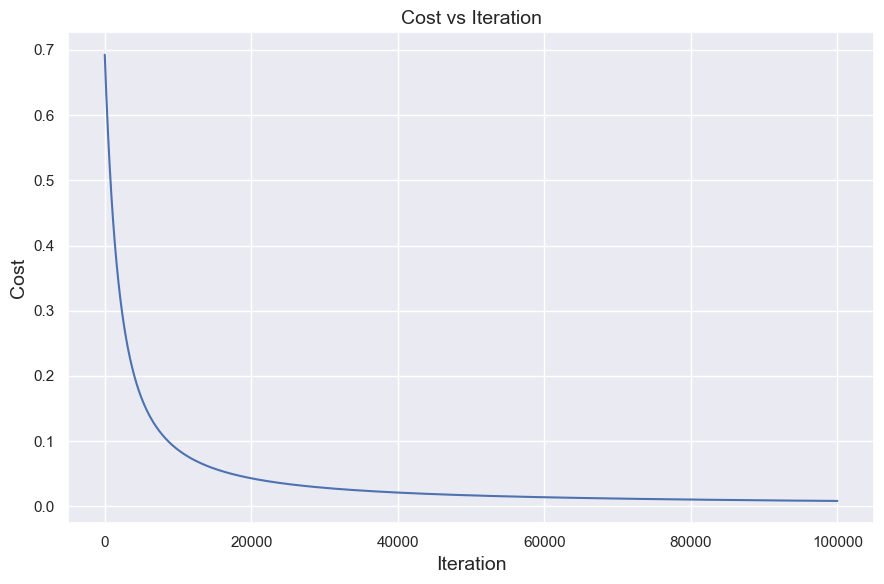

In [147]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

## Preprocessing

In [148]:
# Dropping unnecessary columns
data.drop(['EventId', 'Weight'], axis = 1, inplace = True)

# Replacing -999 with nan
data.replace(to_replace = -999, value = np.nan, inplace = True)

# Encoding the 'Label' column
label_dict = {'b': 0, 's': 1}
#data.replace({'Label': label_dict}, inplace = True)
#replace will be deprecated

# Now perform the replacement
pd.set_option('future.no_silent_downcasting', True)
data.replace({'Label': label_dict}, inplace=True)

In [149]:
# Train-test split
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 40)

In [150]:
# Columns with missing values with respective proportions
(data.isna().sum()[data.isna().sum() > 0] / len(data)).sort_values(ascending = False)

DER_deltaeta_jet_jet      0.709828
DER_mass_jet_jet          0.709828
DER_prodeta_jet_jet       0.709828
PRI_jet_subleading_phi    0.709828
DER_lep_eta_centrality    0.709828
PRI_jet_subleading_eta    0.709828
PRI_jet_subleading_pt     0.709828
PRI_jet_leading_eta       0.399652
PRI_jet_leading_pt        0.399652
PRI_jet_leading_phi       0.399652
DER_mass_MMC              0.152456
dtype: float64

In [151]:
# Discarding columns with more than 30% missing data
cols_missing_drop = [
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality',
    'PRI_jet_subleading_pt',
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi',
    'PRI_jet_leading_pt',
    'PRI_jet_leading_eta',
    'PRI_jet_leading_phi'
]
data_train.drop(cols_missing_drop, axis = 1, inplace = True)
data_test.drop(cols_missing_drop, axis = 1, inplace = True)

In [152]:
# Median imputation
data_train['DER_mass_MMC'] = data_train['DER_mass_MMC'].fillna(data_train['DER_mass_MMC'].median())
data_test['DER_mass_MMC'] = data_test['DER_mass_MMC'].fillna(data_test['DER_mass_MMC'].median())

In [153]:
# Features-target split
X_train, y_train = data_train.drop('Label', axis = 1), data_train['Label']
X_test, y_test = data_test.drop('Label', axis = 1), data_test['Label']

In [154]:
# Min-Max normalization
for col in X_train.columns:
    if (X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64') and X_train[col].nunique() > 1:
        X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())
for col in X_test.columns:
    if (X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64') and X_test[col].nunique() > 1:
        X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

## Model Fitting

In [155]:
# Initial values of the model parameters
w_init = np.array([-5, -15, -10, 9, 4, -6, 3, -10, 1, 14, 0, 0, 15, 0, 0, 7, 0, -3, 1, -8]).astype(float)
b_init = -1.

array([0, 1, 0, ..., 0, 1, 0], shape=(200000,))

In [174]:
# Learning model parameters using gradient descent algorithm
w_out, b_out, cost_history, params_history = grad_desc(
    X_train.to_numpy(),
    y_train.astype(int).to_numpy(),
    w = w_init, # np.zeros(X_train.shape[1]),
    b = b_init, # 0,
    alpha = 0.1,
    n_iter = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:00<16:03,  2.07it/s]

Iteration      0:    Cost  0.5272


 10%|█         | 201/2000 [01:49<16:43,  1.79it/s]

Iteration    200:    Cost  0.5251


 20%|██        | 401/2000 [03:38<12:49,  2.08it/s]

Iteration    400:    Cost  0.5249


 30%|███       | 601/2000 [05:21<12:58,  1.80it/s]

Iteration    600:    Cost  0.5248


 40%|████      | 801/2000 [07:09<09:38,  2.07it/s]

Iteration    800:    Cost  0.5247


 50%|█████     | 1001/2000 [08:54<08:26,  1.97it/s]

Iteration   1000:    Cost  0.5247


 60%|██████    | 1201/2000 [10:36<06:10,  2.16it/s]

Iteration   1200:    Cost  0.5246


 70%|███████   | 1401/2000 [12:18<05:01,  1.99it/s]

Iteration   1400:    Cost  0.5246


 80%|████████  | 1601/2000 [14:01<03:19,  2.00it/s]

Iteration   1600:    Cost  0.5245


 90%|█████████ | 1801/2000 [15:46<01:50,  1.80it/s]

Iteration   1800:    Cost  0.5245


100%|██████████| 2000/2000 [17:29<00:00,  1.90it/s]

Iteration   1999:    Cost  0.5245


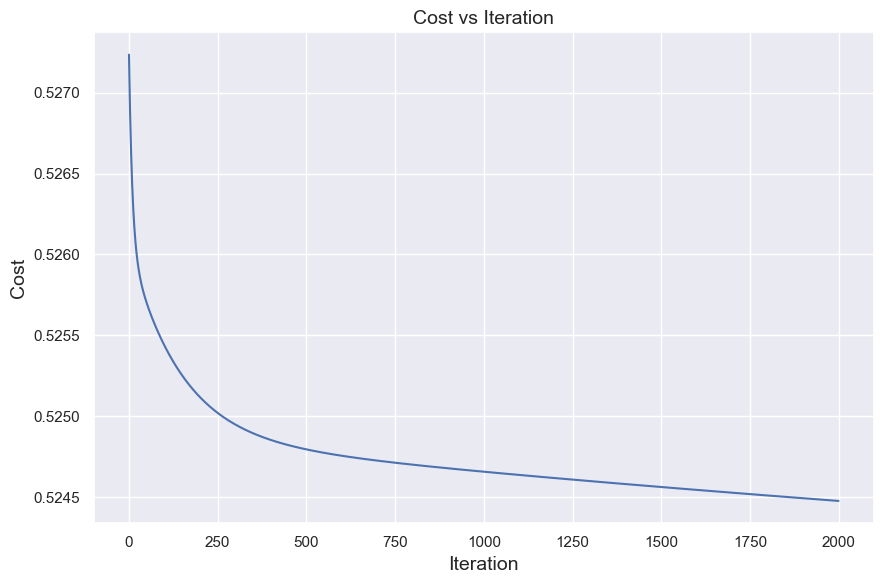

In [175]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [176]:
# Final parameter values
params_history[-1]

[array([-4.95174852e+00, -1.49758660e+01, -1.00649934e+01,  9.02703840e+00,
         4.21150462e+00, -6.01138546e+00,  3.06720457e+00, -1.00917684e+01,
         7.71874815e-01,  1.40215131e+01, -2.92347569e-02, -8.81459084e-03,
         1.49512001e+01, -1.83077784e-02,  4.23685464e-03,  7.04189297e+00,
         1.56071512e-02, -2.95109563e+00,  8.44281904e-01, -7.91952626e+00]),
 np.float64(-1.0358105653553535)]

## Prediction and Evaluation

In [177]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [178]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [179]:
# Function to compute accuracy
def accuracy(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      acc (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    num = confusion_mat[0, 0] + confusion_mat[1, 1] # Number of correct predictions
    denom = num + confusion_mat[0, 1] + confusion_mat[1, 0] # Number of total predictions
    acc = num / denom
    return acc

In [180]:
# Prediction and evaluation on the training set and the test set
y_train_prob = logistic(np.matmul(X_train.to_numpy(), w_out) + (b_out * np.ones(X_train.shape[0])))
y_test_prob = logistic(np.matmul(X_test.to_numpy(), w_out) + (b_out * np.ones(X_test.shape[0])))
y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred),
                 "Test accuracy": accuracy(y_test, y_test_pred)}).to_string())

Training accuracy    0.727935
Test accuracy        0.719880


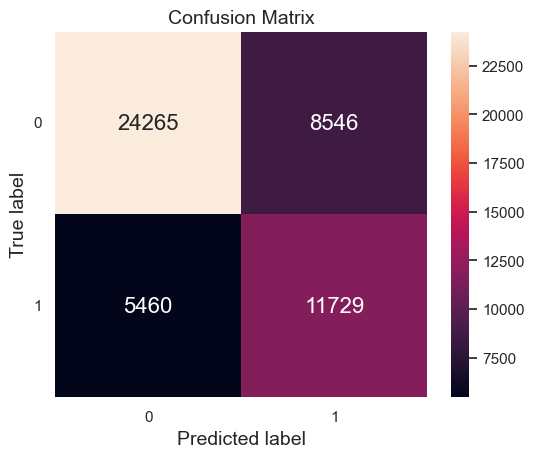

In [181]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred)

## Regularization

In [182]:
# Function to compute regularized cost function in terms of model parameters - using for loops
def cost_logreg_reg(X, y, w, b, l):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost = cost_logreg(X, y, w, b)
    for j in range(n):
        cost += (l / (2 * m)) * (w[j]**2)
    return cost

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"cost_logreg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {cost_logreg_reg(X, y, w, b, l)}")

cost_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = 6.125008350784906


In [183]:
# Function to compute regularized cost function in terms of model parameters - using vectorization
def cost_logreg_vec_reg(X, y, w, b, l):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost = cost_logreg_vec(X, y, w, b)
    cost += (l / (2 * m)) * np.dot(w, w)
    return cost

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"cost_logreg_vec_reg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {cost_logreg_vec_reg(X, y, w, b, l)}")

cost_logreg_vec_reg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = 6.125008350784906


In [184]:
# Function to compute gradients of the regularized cost function with respect to model parameters - using for loops
def grad_logreg_reg(X, y, w, b, l):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = grad_logreg(X, y, w, b)
    for j in range(n):
        grad_w[j] += (l / m) * w[j]
    return grad_w, grad_b

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"grad_logreg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {grad_logreg_reg(X, y, w, b, l)}")

grad_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = (array([-4.74991649,  5.74991649]), np.float64(0.4999916492890759))


In [185]:
# Function to compute gradients of the regularized cost function with respect to model parameters - using vectorization
def grad_logreg_vec_reg(X, y, w, b, l):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = grad_logreg_vec(X, y, w, b)
    grad_w += (l / m) * w
    return grad_w, grad_b

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"grad_logreg_vec_reg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {grad_logreg_vec_reg(X, y, w, b, l)}")

grad_logreg_vec_reg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = (array([-4.74991649,  5.74991649]), np.float64(0.4999916492890759))


In [186]:
# Gradient descent algorithm for logistic regression with regularization
def grad_desc_reg(X, y, w, b, l, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      l (float)                 : regularization parameter
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec_reg(X, y, w, b, l)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec_reg(X, y, w, b, l)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history

In [187]:
# Initial values of the model parameters
w_init = np.array([-5, -15, -10, 9, 4, -6, 3, -10, 1, 14, 0, 0, 15, 0, 0, 7, 0, -3, 1, -8]).astype(float)
b_init = -1.

In [189]:
# Learning model parameters using gradient descent algorithm
w_out_reg, b_out_reg, cost_history_reg, params_history_reg = grad_desc_reg(
    X_train.to_numpy(),
    y_train.astype(int).to_numpy(),
    w = w_init, # np.zeros(X_train.shape[1]),
    b = b_init, # 0,
    l = 1.,
    alpha = 0.1,
    n_iter = 2000)

  0%|          | 1/2000 [00:00<17:24,  1.91it/s]

Iteration      0:    Cost  0.5308


 10%|█         | 201/2000 [01:41<16:49,  1.78it/s]

Iteration    200:    Cost  0.5280


 20%|██        | 401/2000 [03:20<13:55,  1.91it/s]

Iteration    400:    Cost  0.5277


 30%|███       | 601/2000 [04:59<11:22,  2.05it/s]

Iteration    600:    Cost  0.5276


 40%|████      | 801/2000 [06:38<09:59,  2.00it/s]

Iteration    800:    Cost  0.5275


 50%|█████     | 1001/2000 [08:17<08:17,  2.01it/s]

Iteration   1000:    Cost  0.5275


 60%|██████    | 1201/2000 [09:58<06:38,  2.00it/s]

Iteration   1200:    Cost  0.5275


 70%|███████   | 1401/2000 [11:36<04:51,  2.06it/s]

Iteration   1400:    Cost  0.5274


 80%|████████  | 1601/2000 [13:15<03:12,  2.08it/s]

Iteration   1600:    Cost  0.5274


 90%|█████████ | 1801/2000 [14:53<01:36,  2.06it/s]

Iteration   1800:    Cost  0.5274


100%|██████████| 2000/2000 [16:31<00:00,  2.02it/s]

Iteration   1999:    Cost  0.5273


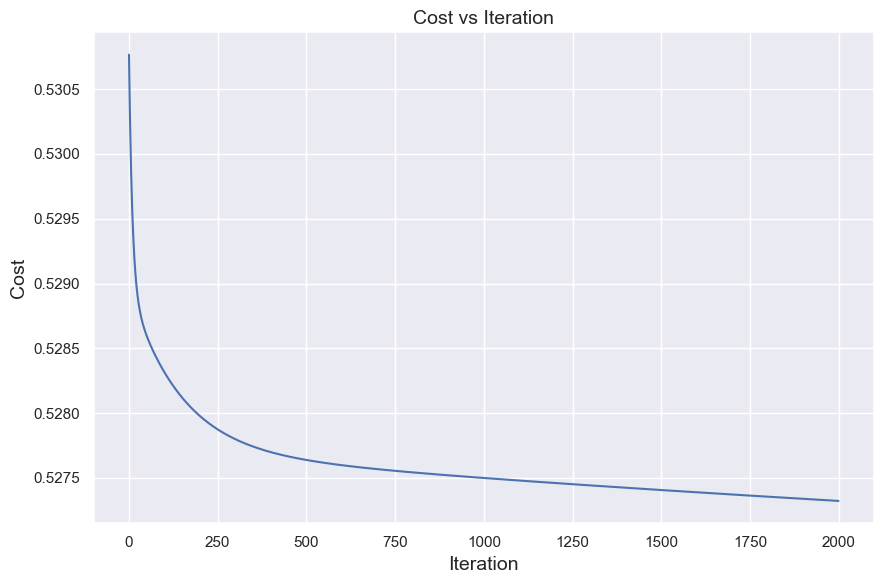

In [190]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history_reg)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [191]:
# Final parameter values
params_history_reg[-1]

[array([-4.94628559e+00, -1.49607208e+01, -1.00543532e+01,  9.01809026e+00,
         4.21009912e+00, -6.00532340e+00,  3.06428729e+00, -1.00811742e+01,
         7.72328943e-01,  1.40078919e+01, -2.85911045e-02, -7.87521465e-03,
         1.49365729e+01, -1.78038152e-02,  5.12711472e-03,  7.03484041e+00,
         1.60760953e-02, -2.94763742e+00,  8.44128051e-01, -7.91172875e+00]),
 np.float64(-1.0392586732889664)]

In [192]:
# Prediction and evaluation on the training set and the test set
y_train_prob_reg = logistic(np.matmul(X_train.to_numpy(), w_out_reg) + (b_out_reg * np.ones(X_train.shape[0])))
y_test_prob_reg = logistic(np.matmul(X_test.to_numpy(), w_out_reg) + (b_out_reg * np.ones(X_test.shape[0])))
y_train_pred_reg, y_test_pred_reg = (y_train_prob_reg > 0.5).astype(int), (y_test_prob_reg > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred_reg),
                 "Test accuracy": accuracy(y_test, y_test_pred_reg)}).to_string())

Training accuracy    0.727915
Test accuracy        0.719900


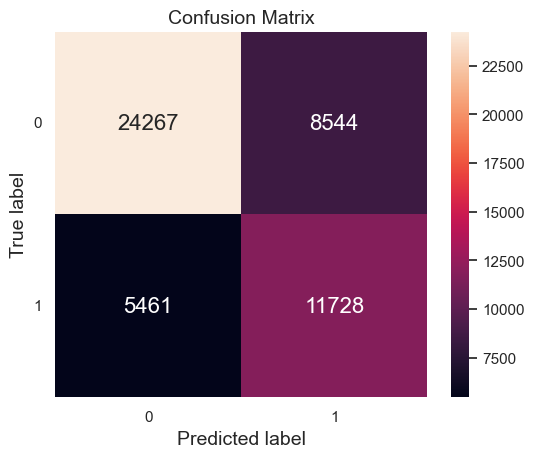

In [193]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred_reg)

In [194]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         39683.05 seconds
Process memory usage           112.24 MB
